In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from pytorchtools import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'BaselineModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class BaselineModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = BaselineModel()

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3777


In [13]:
# Pass model to GPU
model.to(device)

BaselineModel(
  (TextModel): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [14]:
epochs = 5

# Define hyperparameters
batch_size = 64
learning_rate = .05

In [15]:
# Define loss function
loss_function = nn.MSELoss().to(device)

In [16]:
# Define optimization alogrithm
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [17]:
# Define early stopping condition
stop_early = EarlyStopping(patience=3, delta=0, path=f'../models/{model_name}/state_dict.pt')

In [18]:
# Create data loaders
dataloader_train = DataLoader(subsets['train'], batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_val = DataLoader(subsets['val'], batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [23]:
# Create data frame for storing training history
history = pd.DataFrame(index=pd.Index(np.arange(epochs) + 1, name='epoch'))

In [24]:
# Training loop
for epoch in np.arange(epochs) + 1:
    # Activate training mode
    model.train()

    # Create list for storing batch losses
    batch_losses_train = []

    # Iterate over all training batches
    for i, sample in enumerate(dataloader_train):
        # Pass batch to GPU
        X, y = [X.to(device) for X in sample[:-1]], sample[-1].to(device)

        # Reset gradients
        model.zero_grad()

        # Run forward pass
        output_train = model(*X)

        # Compute batch loss
        batch_loss_train = loss_function(output_train, y)

        # Run backward pass
        batch_loss_train.backward()

        # Optimise parameters
        optimizer.step()

        # Store batch loss
        batch_losses_train.append(batch_loss_train.data.item())
    
    # Calculate training loss
    epoch_rmse_train = np.mean(batch_losses_train)**.5

    # Store training loss in history
    history.loc[epoch, 'RMSE_train'] = epoch_rmse_train.item()

    # Activate validation mode
    model.eval() # deactivates potential Dropout and BatchNorm
    
    # Create list for storing batch losses
    batch_losses_val = []

    # Iterate over all validation batches
    for i, sample in enumerate(dataloader_val):
        with torch.no_grad():
            # Pass batch to GPU
            X, y = [X.to(device) for X in sample[:-1]], sample[-1].to(device)

            # Run forward pass
            output_val = model(*X)

            # Compute batch loss
            batch_loss_val = loss_function(output_val, y)

            # Store batch loss
            batch_losses_val.append(batch_loss_val.data.item())

    # Calculate validation loss
    epoch_rmse_val = np.mean(batch_losses_val)**.5

    # Store validation loss in history
    history.loc[epoch, 'RMSE_val'] = epoch_rmse_val.item()
    
    # Print progress to console
    print(f'Epoch {epoch:{len(str(epochs))}.0f}/{epochs}: RMSE_train: {epoch_rmse_train.item():,.0f}, RMSE_val: {epoch_rmse_val.item():,.0f}')

    # Stop early in case validation loss does not improve
    stop_early(epoch_rmse_val, model)
    if stop_early.early_stop:
        print("Early stopping condition met")
        break
        
# Load the best model
model.load_state_dict(torch.load(stop_early.path))


Epoch 1/5: RMSE_train: 824,227, RMSE_val: 947,917
Epoch 2/5: RMSE_train: 781,788, RMSE_val: 954,398
EarlyStopping counter: 1 out of 3
Epoch 3/5: RMSE_train: 769,452, RMSE_val: 952,537
EarlyStopping counter: 2 out of 3
Epoch 4/5: RMSE_train: 763,806, RMSE_val: 935,486
Epoch 5/5: RMSE_train: 760,237, RMSE_val: 942,133
EarlyStopping counter: 1 out of 3


<All keys matched successfully>

In [25]:
# Save training history
history.to_csv(f'../models/{model_name}/history.csv')

In [40]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

[tensor([[-0.6524, -0.3941, -0.7030, -0.6528, -0.2633, -0.6075, -0.4352, -0.1661,
         -0.3767, -0.5946, -0.1157, -0.1047, -0.1151,  0.0243, -0.1144, -1.5848,
         -0.9719, -0.4332,  0.7710,  1.1581,  0.3023, -0.9391, -1.0092,  0.7199,
         -1.0087]])]
tensor([[980000.]])
['train', 'val', 'test']


TypeError: to() received an invalid combination of arguments - got (list), but expected one of:
 * (torch.device device, torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (Tensor tensor, bool non_blocking, bool copy, *, torch.memory_format memory_format)


In [ ]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE      R2
----------------------------------------------
train   1142163.080  654771.451  0.950   0.163
val     1368245.443  676120.940  1.104  -0.222
test    1134264.398  666491.045  0.982   0.169
----------------------------------------------
total   1165199.789  659250.062  0.972   0.126


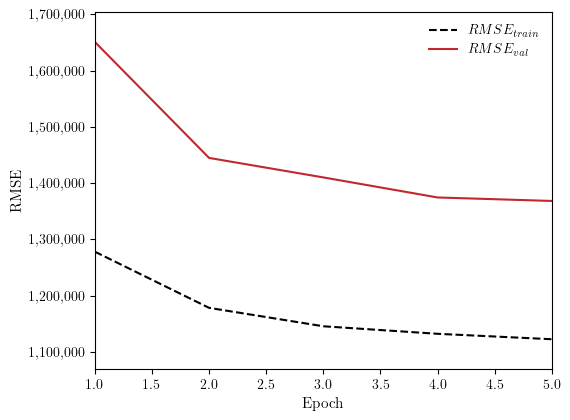

In [ ]:
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

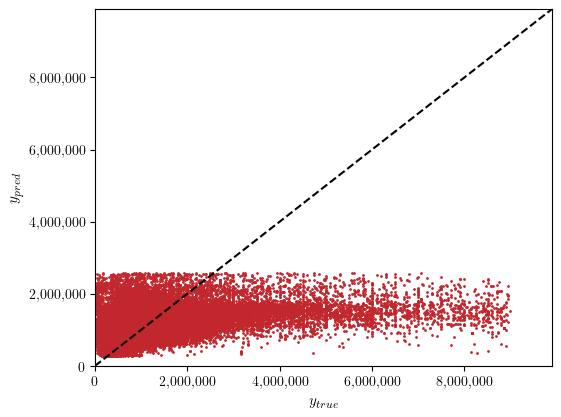

In [ ]:
sf.plot_scatter(predictions, save_as=f'../models/{model_name}/scatter.pdf')

/Users/jonas/Library/CloudStorage/OneDrive-Personal/02_Education/02_Bachelor_Business-Administration/Bachelors-Thesis/Repository/src/shared_functions.py:745: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))


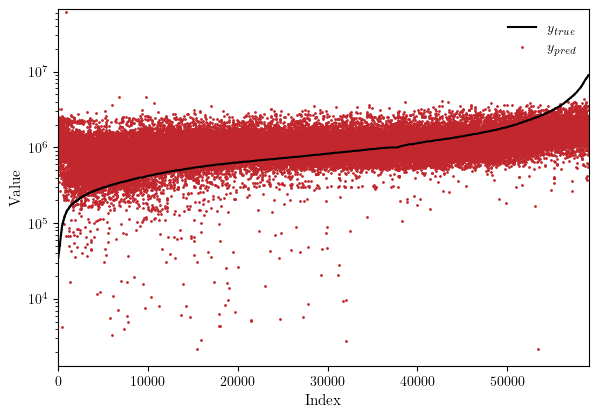

In [ ]:
sf.plot_log(predictions, save_as=f'../models/{model_name}/log.pdf')